# Feature Engineering

In [1]:
# dependencies
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import Counter

import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import seaborn as sns 

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA


import gensim
from gensim.models.doc2vec import TaggedDocument


import multiprocessing

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
# ! pip install imbalanced-learn
# check version number
import imblearn
# print(imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

# ! pip install ipympl
# %matplotlib widget

/Users/laura/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('dataset_cleaned.csv', encoding = 'utf-8-sig', engine = 'python')

In [3]:
df.head()

,text,label,char_count,word_count,avg_word,avg_text
0,the hard working american vs the government parasite by michael snyder april th which lifestyle choice produce better result hard work american government parasite actually look cold hard number m...,1,85051,13419,5.338177,71633
1,how many people will have to migrate out of california when all the water disappears april nd the drought california get lot worse as read this snowpack level sierra nevada mountains lowest ever r...,1,76315,11720,5.511604,64596
2,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,1,74287,11584,5.412983,62704
3,why are so many people choosing to leave the united states permanently august th have things get bad time leave united states good that question lot americans deal days increase number choose leav...,1,74287,11584,5.412983,62704
4,why is obama threatening russia with world war right before the election october th it sure seem like odd time provoke war russia as write this stand little bite three weeks away one pivotal elect...,1,64908,10261,5.325797,54648


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75982 entries, 0 to 75981
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   text        75189 non-null  object 
 1   label       75982 non-null  int64  
 2   char_count  75982 non-null  int64  
 3   word_count  75982 non-null  int64  
 4   avg_word    75982 non-null  float64
 5   avg_text    75982 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 3.5+ MB


In [5]:
texts = df['text'].astype('str')
labels = df['label']

In [6]:
#keep the same random state for reproducibility
RANDOM_STATE_SMOTE = 12
RANDOM_STATE = 1000
TRAIN_TEST_SPLIT_SIZE = .1
VALIDATION_SPLIT_SIZE = .2

In [7]:
wpt = nltk.WordPunctTokenizer()
tokenized_texts = [wpt.tokenize(text) for text in texts]

In [8]:
x_train_val, x_test, y_train_val, y_test = train_test_split(tokenized_texts, labels,
                                                  test_size = TRAIN_TEST_SPLIT_SIZE, stratify = labels,
                                                  random_state = RANDOM_STATE)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val,
                                                  test_size = VALIDATION_SPLIT_SIZE, stratify = y_train_val,
                                                  random_state = RANDOM_STATE)

In [10]:
np.save("train_dataset_features.npy", np.array(x_train))
np.save("train_dataset_labels.npy", np.array(y_train))

<ipython-input-10-a5bf1913d7ee>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.save("train_dataset_features.npy", np.array(x_train))


In [11]:
np.save("test_dataset_features.npy", np.array(x_test))
np.save("test_dataset_labels.npy", np.array(y_test))

<ipython-input-11-2c7c40d379f6>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.save("test_dataset_features.npy", np.array(x_test))


In [12]:
np.save("val_dataset_features.npy", np.array(x_val))
np.save("val_dataset_labels.npy", np.array(y_val))

<ipython-input-12-6840e88999c6>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.save("val_dataset_features.npy", np.array(x_val))


**Feature Extraction from Text**

To analyse a preprocessed data, it needs to be converted into features. Since numerical features ease the processing and statistical analysis, most machine learning algorithms require a numerical representation of objects as features. For this reason, feature extraction techniques are employed to convert the textual data into numerical features. The most popular and simple methods of feature extraction with text data currently used are:

- Bag of Words
- TF-IDF
- Word embeddings


**TF-IDF**

Defition according to Wikipedia: “Term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.” 

The widely used feature extraction technique that in the past was traditionally used for text is TF-IDF. This technique has been proven to work well with text data and traditional algorithms and is also quite explainable. TF-IDF generates features of size N x V, where N is the number of observations and V is the vocabulary size. This approach can help reduce the size of the features to the choice of embedding size.

The idea behind the TF-IDF approach is that the words that occur less in all the documents and more in individual document contribute more towards classification. TF-IDF is a combination of two terms. Term frequency and Inverse Document frequency. TF is a measure of how frequently a term appears in a document. IDF is a measure of how important a term is. We need the IDF value because computing just the TF alone is not sufficient to understand the importance of words.

***

For the technical implementation I will use the TfidfVectorizer from scikit-learn.


TfidfVectorizer has a few important parameters: 
- stop_words:  Stop words are just a list of words we don’t want to use as features. This parameter defaults to None. In the preprocessing part, I already removed some of the stop words, so I will not use this parameter here.
- min_df parameter is a threshold value where we ignore terms that have a document frequency lower than min_df. If rare words only occur once or twice, they won't add much value and are usually really obscure. Furthermore, there's generally a lot of them so ignoring them with say min_df=5 can greatly reduce your memory consumption and data size. Generally putting min_df 5-10 is a good balance, because you also filter misspelled words. 
- max_df is the contrast of min_df parameter. If the document frequency of a word is more than max_df, we ignore it. max_df = 0.90 means "ignore terms that appear in more than 90% of the documents/less than 10% of the documents".
- max_features

Let's explore different parameters for feature extraction for count vectorizer to see the effect of the parameters. Logistic regression is a simple and fast classifier. Due to its simplicity, it’s often a good  classifier to try.

**Note:** Normally one would tune the parameters of the TF-IDF vectorizer together with the hyperparameters of the individual classifiers inside the pipeline, which is something I've tried to but turned out to be very computationally expensive, with up to 1200 parameters to tune inside a GridSearchCV, which is why I've decided to extract the features separately, and try to tune as much as possible here.

In [13]:
logreg = LogisticRegression()

In [14]:
skf = StratifiedKFold(n_splits = 5)

In [15]:
max_feature_params = [10000, 20000, 25000]
max_feature_score = []

for p in max_feature_params:
    tfidf_vectorizer = TfidfVectorizer(tokenizer = lambda x: x,
                        preprocessor = lambda x: x, max_features = p)

    tfidf = tfidf_vectorizer.fit_transform(x_train_val) 
    score = cross_val_score(logreg, tfidf, y_train_val, cv = skf, scoring = 'f1')
    max_feature_score.append(score.mean())

/Users/laura/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laura/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [16]:
max_features = ['max_f=' + str(p) for p in max_feature_params]
# put everything in a dataframe
max_features_df = pd.DataFrame({'params':max_features, 'scores':max_feature_score}, index = [0,1,2])

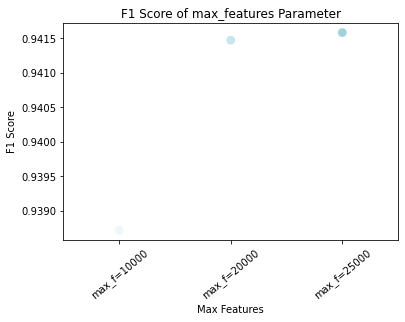

In [17]:
sns.pointplot(x ='params', y ='scores', data = max_features_df, palette = sns.light_palette((210, 90, 60), input = "husl"), markers = ["o"])
plt.ylabel('F1 Score')
plt.xlabel('Max Features')
plt.xticks(rotation = 40)
plt.title('F1 Score of max_features Parameter')
plt.show()

In [18]:
max_df_params = [0.5, 0.75, 0.8, 0.9, 1.0]
max_df_score = []

for p in max_df_params:
    tfidf_vectorizer = TfidfVectorizer(tokenizer = lambda x: x,
                        preprocessor = lambda x: x, max_df = p)

    tfidf = tfidf_vectorizer.fit_transform(x_train_val) 
    score = cross_val_score(logreg, tfidf, y_train_val, cv = skf, scoring = 'f1')
    max_df_score.append(score.mean())

/Users/laura/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/laura/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [19]:
max_dfs = ['max_df=' + str(p) for p in max_df_params]
# dataframe for scores
max_df_df = pd.DataFrame({'params':max_dfs, 'scores':max_df_score}, index = [0,1,2,3,4])

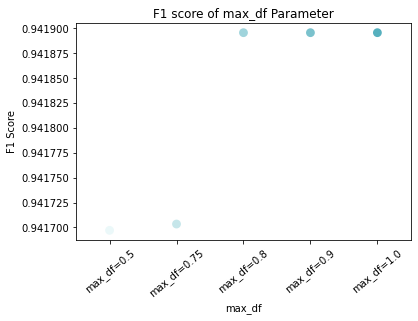

In [20]:
sns.pointplot(x = 'params', y = 'scores', data = max_df_df, palette = sns.light_palette((210, 90, 60), input = "husl"), markers = ["o"])
plt.ylabel('F1 Score')
plt.xlabel('max_df')
plt.xticks(rotation = 40)
plt.title('F1 score of max_df Parameter')
plt.show()

The linear regression model does not seem to converge, maybe there's some multicolinearity that's leading to coefficients that change substantially without actually affecting many predictions/scores.

Another possibility is that we're getting near-perfect separation on the training set (which seems to be the case based on the results). In unpenalized logistic regression, a linearly separable dataset won't have a best fit: the coefficients will blow up to infinity (to push the probabilities to 0 and 1). When you add regularization, it prevents those gigantic coefficients. So, with large values of C , i.e. little regularization, we still get large coefficients and so convergence may be slow, but the partially-converged model may still be quite good on the test set; whereas with large regularization we get much smaller coefficients, and worse performance on both the training and test sets.

I could try increasing n_iter, changing the solver, or scaling features (though with the tf-idf, I wouldn't think that'd help).

Right now, I'm only concerned with feature extraction, and I'll look for the largest C that gives good results, then go about trying to get that to converge with more iterations and/or different solvers when I try the different models.

Based on these results I will use max_df=0.75 to control the maximum number of documents any term can be found in. If 75% of texts contain the same word then it’s so common that it’s not very useful. min_df set to 5, as per explanation above.

For the number of features, I'll use 25'000 (although I have a feeling it is quite a lot).

**Creating Bigram and Trigram Models**

I will use TF-IDF with an n-gram range of (1,3).

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Hopefully by adding ngram parameter, we are able to understand phrase like "not good" and other relevant combinations.

In [21]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = lambda x: x,
                        preprocessor = lambda x: x, 
                        min_df = 5, max_df = 0.75, max_features = 25000, ngram_range = (1,3)) 
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train) 
x_test_tfidf = tfidf_vectorizer.transform(x_test)
x_val_tfidf = tfidf_vectorizer.transform(x_val)

x_train_tfidf.shape

(54706, 25000)

In [22]:
len(tfidf_vectorizer.vocabulary_)

25000

In [23]:
# return a list of (term, score/frequency) pairs for each distinct term 
scores = np.asarray(x_train_tfidf.mean(axis = 0)).ravel().tolist()
scores_df = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names(), 'tfidf': scores})
df_tfidf = scores_df.sort_values(by = 'tfidf', ascending = False).head(50)

In [24]:
df_tfidf

,word,tfidf
22314,trump,0.038532
23141,us,0.019914
24536,would,0.017621
16007,president,0.017279
3523,clinton,0.016809
15175,people,0.016344
20006,state,0.015922
13259,mr,0.015418
10409,it,0.014225
14428,one,0.014204


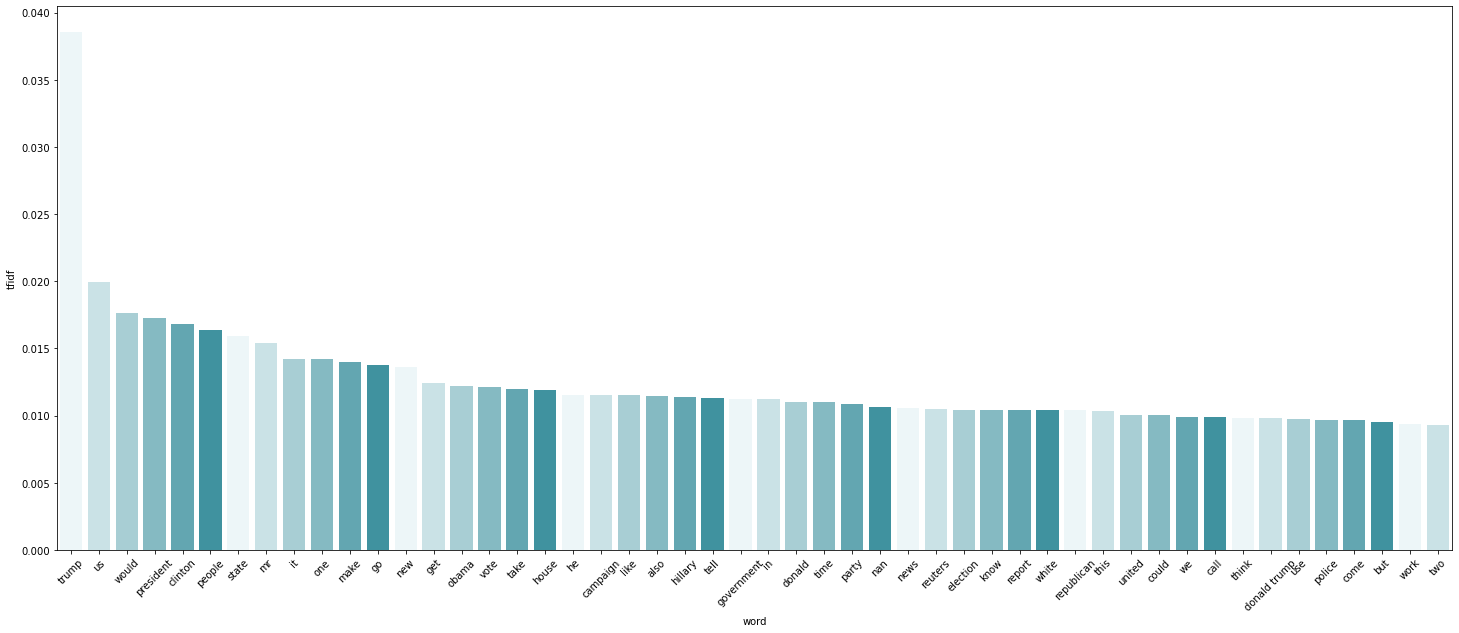

In [25]:
plt.figure(figsize = (25,10))
sns.barplot(x = 'word', y = 'tfidf', data = df_tfidf, palette = sns.light_palette((210, 90, 60), input = "husl"))
plt.xticks(rotation = 45)
plt.show()

For example we see here that by adding the ngrams we were able to capture "donald trump" as one of the top words (and word combinations).

***

**Prepare features**

***

In [26]:
np.save("train_dataset_tfidf_features.npy", np.array(x_train_tfidf))
np.save("train_dataset_tfidf_labels.npy", np.array(y_train))

In [27]:
np.save("val_dataset_tfidf_features.npy", np.array(x_val_tfidf))
np.save("val_dataset_tfidf_labels.npy", np.array(y_val))

In [28]:
np.save("test_dataset_tfidf_features.npy", np.array(x_test_tfidf))
np.save("test_dataset_tfidf_labels.npy", np.array(y_test))

***

**Visualize TF-IDF embeddings**

***

In [29]:
print(repr(x_train_tfidf))

<54706x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 12716331 stored elements in Compressed Sparse Row format>


The TF-IDF features form a sparse matrix, which we can try to visualize using a heatmap and select only 100 dimension to preserve a certain visibility.

Text(0.5, 1.0, 'Sparse Matrix 100 Sample')

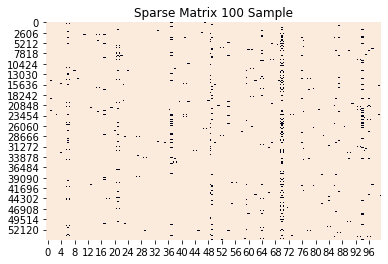

In [30]:
sns.heatmap(x_train_tfidf.todense()
            [:,np.random.randint(0, x_train_tfidf.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix 100 Sample')

One very popular method for visualizing document similarity is to use t-distributed stochastic neighbor embedding, t-SNE.

For high-dimensional sparse data it is helpful to first reduce the dimensions to let's say 50 dimensions with TruncatedSVD and then perform t-SNE. This should improve the visualization.

In [31]:
from sklearn.decomposition import TruncatedSVD
X_red = TruncatedSVD(n_components = 50, random_state = RANDOM_STATE).fit_transform(x_train_tfidf)

An important feature of t-SNE is a tuneable parameter, “perplexity,” which says (loosely) how to balance attention between local and global aspects of the data. The parameter is, in a sense, a guess about the number of close neighbors each point has. The perplexity value has a complex effect on the resulting pictures. The original paper says, “The performance of SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50.”


My intuition about how the perplexity parameter in t-SNE works is that it sets the effective number of neighbours that each point is attracted to. So if the perplexity is very small, then there will be fewer pairs that feel any attraction and the resulting embedding will tend to be "fluffy".

On the other hand, if the perplexity is large, clusters will tend to shrink into denser structures.

I will try with a relatively low perplexity and a very high perplexity.

In [32]:
from  sklearn.manifold import TSNE
#Perplexity 10
X_tsne = TSNE(n_components = 2, perplexity = 10, verbose = 2).fit_transform(X_red)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 54706 samples in 0.003s...
[t-SNE] Computed neighbors for 54706 samples in 72.596s...
[t-SNE] Computed conditional probabilities for sample 1000 / 54706
[t-SNE] Computed conditional probabilities for sample 2000 / 54706
[t-SNE] Computed conditional probabilities for sample 3000 / 54706
[t-SNE] Computed conditional probabilities for sample 4000 / 54706
[t-SNE] Computed conditional probabilities for sample 5000 / 54706
[t-SNE] Computed conditional probabilities for sample 6000 / 54706
[t-SNE] Computed conditional probabilities for sample 7000 / 54706
[t-SNE] Computed conditional probabilities for sample 8000 / 54706
[t-SNE] Computed conditional probabilities for sample 9000 / 54706
[t-SNE] Computed conditional probabilities for sample 10000 / 54706
[t-SNE] Computed conditional probabilities for sample 11000 / 54706
[t-SNE] Computed conditional probabilities for sample 12000 / 54706
[t-SNE] Computed conditional probabilities for sa

Populating the interactive namespace from numpy and matplotlib


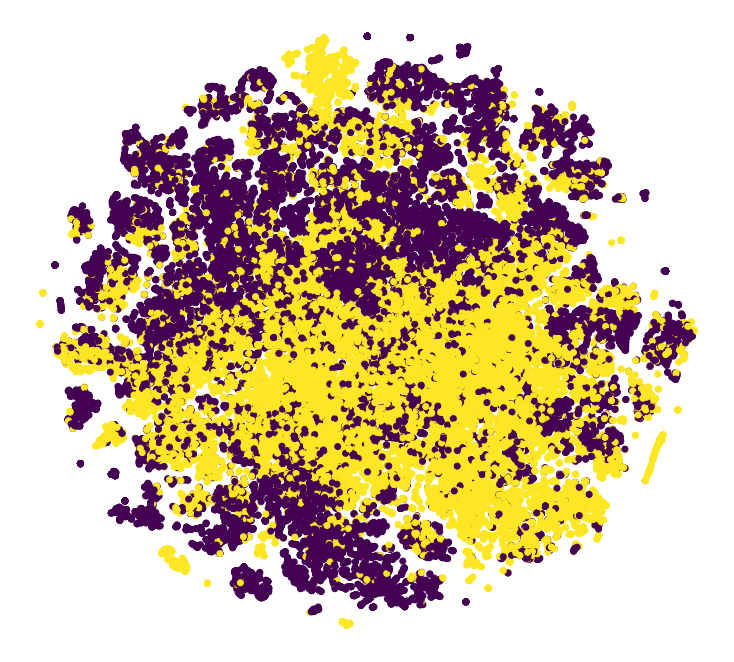

In [33]:
%pylab inline
figure(figsize = (10, 10))
ax = axes(frameon = False)
setp(ax, xticks = (), yticks = ())
subplots_adjust(left = 0.0, bottom = 0.0, right = 1.0, top = 0.9, wspace = 0.0, hspace = 0.0) 
scatter(X_tsne[:, 0], X_tsne[:, 1], c = y_train)

As we noticed when we plotted the top words in each class, we are not able to clearly separate between the two classes. We also do not clearly see the formation of clusters, so I will give it another try with a higher perplexity.

In [34]:
#Perplexity 100
X_tsne = TSNE(n_components = 2, perplexity = 100, verbose = 2).fit_transform(X_red)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 54706 samples in 0.002s...
[t-SNE] Computed neighbors for 54706 samples in 81.151s...
[t-SNE] Computed conditional probabilities for sample 1000 / 54706
[t-SNE] Computed conditional probabilities for sample 2000 / 54706
[t-SNE] Computed conditional probabilities for sample 3000 / 54706
[t-SNE] Computed conditional probabilities for sample 4000 / 54706
[t-SNE] Computed conditional probabilities for sample 5000 / 54706
[t-SNE] Computed conditional probabilities for sample 6000 / 54706
[t-SNE] Computed conditional probabilities for sample 7000 / 54706
[t-SNE] Computed conditional probabilities for sample 8000 / 54706
[t-SNE] Computed conditional probabilities for sample 9000 / 54706
[t-SNE] Computed conditional probabilities for sample 10000 / 54706
[t-SNE] Computed conditional probabilities for sample 11000 / 54706
[t-SNE] Computed conditional probabilities for sample 12000 / 54706
[t-SNE] Computed conditional probabilities for s

Populating the interactive namespace from numpy and matplotlib


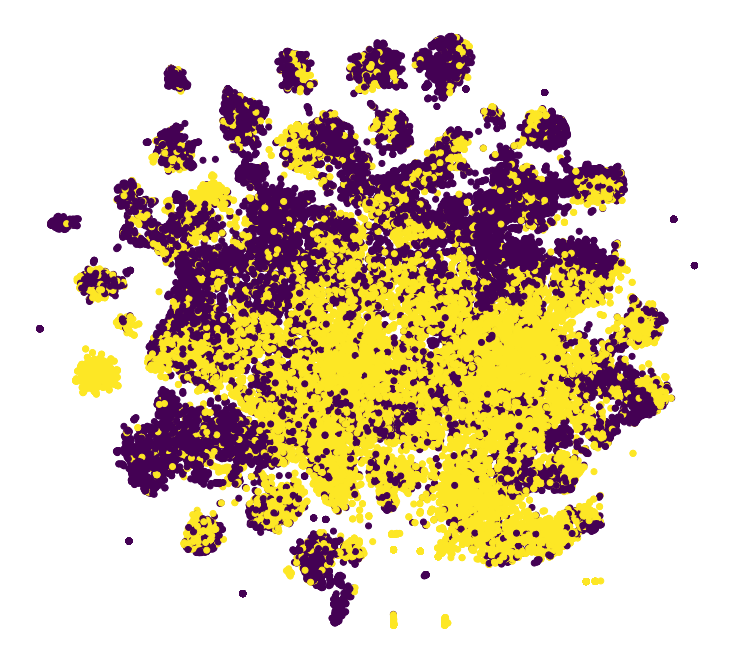

In [35]:
%pylab inline
figure(figsize = (10, 10))
ax = axes(frameon = False)
setp(ax, xticks = (), yticks = ())
subplots_adjust(left = 0.0, bottom = 0.0, right = 1.0, top = 0.9, wspace = 0.0, hspace = 0.0) 
scatter(X_tsne[:, 0], X_tsne[:, 1], c = y_train)

Here we notice a stronger formation of clustering. Maybe increasing the perplexity would help, but probably not by much, since we already know that we have very little separation between the classes.

The two classes do not look very well separated, which could in theory be a feature of our embeddings or simply of our dimensionality reduction. Since we already know the classes are overlapping, we can safely say it's a feature of our embeddings.